In [1]:
#importing necessary libraries
import pandas as pd
from datetime import datetime as dt

In [2]:
#reading the weather data
weather = pd.read_csv('weather-sfcsv.csv')

In [3]:
#reading the train dataset
train = pd.read_csv('train.csv')

In [4]:
#reading the test dataset
test = pd.read_csv('test.csv')

In [5]:
#converting the XML holidays file to pandas dataframe
import xml.etree.ElementTree as Xet
  
cols = ["date","description"]
rows = []
  
# Parsing the XML file
xmlparse = Xet.parse("holidays.xml")
root = xmlparse.getroot()
for i in root:
    date = i.find("date").text
    description = i.find("description").text
    
  
    rows.append({"date": date,
                 "description": description,
                 })
  
holidays = pd.DataFrame(rows, columns=cols)

In [6]:
#a function that merges the holidays dataset with another given dataset
def mergeholidays(train,holidays):
    train['date'] = train['timestamp'].str.slice(stop=10)
    train = pd.merge(train,holidays,on = 'date',how = 'left')
    #train[['description']]=train[['description']].fillna("not holiday")
    train['description']=train['description'].notna()
    return train

In [7]:
#merging train and holidays dataset
train=mergeholidays(train,holidays)

In [8]:
#changing the format of the strings in the Month Day Hour columns in the weather dataset
weather['Month'] = weather['Month'].map("{:02}".format)            
weather['Day'] = weather['Day'].map("{:02}".format) 
weather['Hour'] = weather['Hour'].map("{:02}".format) 
weather['datedate'] = weather["Year"].apply(str)+"-"+weather["Month"].apply(str)+"-"+weather["Day"].apply(str)+" "+weather["Hour"].apply(str)
#dropping the columns that are not needed
weather1 = weather.drop(['Wind_Chill(F)','Precipitation(in)','Year','Month','Day','Hour','Selected',],1)

In [9]:
#spliting the windy condition from the Weather_condition column in the weather dataset and adding it to a seperate column
windy = []
conditions=[]
for i in range(len(weather1)):
    cond=weather1['Weather_Condition'].iloc[i]
    if ("/" in str(weather1['Weather_Condition'].iloc[i])) :
        cond=weather1['Weather_Condition'].iloc[i].split('/')[0].strip()
        windy.append(1)
    else:
        windy.append(0)
    conditions.append(cond)
weather1['Windy'] = windy
weather1['Weather_Condition']=conditions

In [10]:
#imputing the missing values of of the weather dataset by the mean of the column
from sklearn.impute import SimpleImputer
import numpy as np
miss_mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

miss_mean_imputer = miss_mean_imputer.fit(weather1[['Temperature(F)','Visibility(mi)','Wind_Speed(mph)','Humidity(%)']])

weather1[['Temperature(F)','Visibility(mi)','Wind_Speed(mph)','Humidity(%)']] = miss_mean_imputer.transform(weather1[['Temperature(F)','Visibility(mi)','Wind_Speed(mph)','Humidity(%)']])

In [11]:
weather1.dropna(inplace = True)
weather1.reset_index(drop = True)

,Weather_Condition,Temperature(F),Humidity(%),Wind_Speed(mph),Visibility(mi),datedate,Windy
0,Fair,64.0,70.0,20.0,10.0,2020-07-27 18,0
1,Partly Cloudy,71.1,57.0,9.2,10.0,2017-09-30 17,0
2,Overcast,57.9,87.0,15.0,9.0,2017-06-27 05,0
3,Clear,66.9,73.0,4.6,10.0,2016-09-07 09,0
4,Fair,52.0,89.0,0.0,9.0,2019-10-19 02,0
...,...,...,...,...,...,...,...
6895,Clear,51.1,80.0,3.5,10.0,2018-01-23 21,0
6896,Cloudy,56.0,80.0,9.0,9.0,2019-06-16 07,0
6897,Rain,61.0,90.0,32.2,7.0,2017-02-07 04,0
6898,Mostly Cloudy,61.0,67.0,21.9,10.0,2016-04-22 16,0


In [12]:
#removing duplicates in weather data
weather2=weather1.loc[weather1['datedate'].duplicated()==False]

In [13]:
#function to left join data and weather data
def mergeweather(train,weather2):
    train['datedate'] = train['timestamp'].str.slice(stop=13)
    train = pd.merge(train,weather2,on = 'datedate',how = 'left')
    return train

In [14]:
train=mergeweather(train,weather2)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6407 entries, 0 to 6406
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 6407 non-null   int64  
 1   Lat                6407 non-null   float64
 2   Lng                6407 non-null   float64
 3   Bump               6407 non-null   bool   
 4   Distance(mi)       6407 non-null   float64
 5   Crossing           6407 non-null   bool   
 6   Give_Way           6407 non-null   bool   
 7   Junction           6407 non-null   bool   
 8   No_Exit            6407 non-null   bool   
 9   Railway            6407 non-null   bool   
 10  Roundabout         6407 non-null   bool   
 11  Stop               6407 non-null   bool   
 12  Amenity            6407 non-null   bool   
 13  Side               6407 non-null   object 
 14  Severity           6407 non-null   int64  
 15  timestamp          6407 non-null   object 
 16  date               6407 

In [15]:
#clean full data from null values
def clean(train):
    train.dropna(inplace = True)
    train.reset_index(drop = True)
    return train

def timeCategories2(x):
    if x.hour>= 0 and x.hour < 4:
        return '1'
    if x.hour>= 4 and x.hour<8:
        return '2'
    elif x.hour >= 8 and x.hour < 12:
        return '3'
    elif x.hour >= 12 and x.hour < 16:
        return '4'
    elif x.hour >= 16 and x.hour < 20:
        return '5'
    else:
        return '6'



In [16]:
#a function to split time into night and day segments    
def timeCategories(x):
    if x.hour>= 6 and x.hour < 18:
        return 1
    else:
        return 0



In [17]:
#a function to split days into weekdays  
def weekdaycat(x):
    if x in [0,1,2,3,4]:
        return 0
    else:
        return 1


In [18]:
#a function to split months into seasons
def seasons(x):
    if x.month in [1,2,3]:
        return '0'
    elif x.month in [4,5,6]:
        return '1'
    elif x.month in [7,8,9]:
        return '2'
    elif x.month in [10,11,12]:
        return '3'

    


In [19]:
#encoding categorical data into numerical
def encoding(train):
    train=train.replace(False,0)
    train=train.replace(True,1)
    train=train.replace('R',0)
    train=train.replace('L',1)
    
    y=pd.get_dummies(train['description'], prefix='day')
    train=pd.concat([train,y],axis=1)
    
    y2=pd.get_dummies(train['Weather_Condition'], prefix='Weather')
    train=pd.concat([train,y2],axis=1)
    
    #train['Weather_other']=train['Weather_Mist']+train['Weather_Light Drizzle']+train['Weather_Squalls']+train['Weather_Patches of Fog']+train['Weather_Light Thunderstorms and Rain']
   
    
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    train['time_category'] = train['timestamp'].apply(timeCategories)
    train['weekday']=pd.to_datetime(train['date']).apply(dt.weekday)
    #train['weekday']=train['weekday'].apply(weekdaycat)
    
    y3=pd.get_dummies(train['time_category'], prefix='time_category')
    train=pd.concat([train,y3],axis=1)
    
    y4=pd.get_dummies(train['weekday'], prefix='weekday')
    train=pd.concat([train,y4],axis=1)
    L=['Weather_Mist','Weather_Light Drizzle','Weather_Squalls','Weather_Patches of Fog','Weather_Light Thunderstorms and Rain']
    for i in L:
        if i in train.columns:
            train=train.drop(i,axis=1)
    return train

train=clean(train)
train=encoding(train)

In [20]:
def encoding2(train):
    train=train.replace(False,0)
    train=train.replace(True,1)
    train=train.replace('R',0)
    train=train.replace('L',1)
    
    y=pd.get_dummies(train['description'], prefix='day')
    train=pd.concat([train,y],axis=1)
    
    y2=pd.get_dummies(train['Weather_Condition'], prefix='Weather')
    train=pd.concat([train,y2],axis=1)

    train['Weather_other']=train['Weather_Light Drizzle']
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    train['time_category'] = train['timestamp'].apply(timeCategories)
    train['weekday']=pd.to_datetime(train['date']).apply(dt.weekday)
    
    y3=pd.get_dummies(train['time_category'], prefix='time_category')
    train=pd.concat([train,y3],axis=1)
    
    y4=pd.get_dummies(train['weekday'], prefix='weekday')
    train=pd.concat([train,y4],axis=1)
    return train

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6406 entries, 0 to 6406
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ID                        6406 non-null   int64         
 1   Lat                       6406 non-null   float64       
 2   Lng                       6406 non-null   float64       
 3   Bump                      6406 non-null   float64       
 4   Distance(mi)              6406 non-null   float64       
 5   Crossing                  6406 non-null   float64       
 6   Give_Way                  6406 non-null   float64       
 7   Junction                  6406 non-null   float64       
 8   No_Exit                   6406 non-null   float64       
 9   Railway                   6406 non-null   float64       
 10  Roundabout                6406 non-null   float64       
 11  Stop                      6406 non-null   float64       
 12  Amenity             

<BarContainer object of 47 artists>

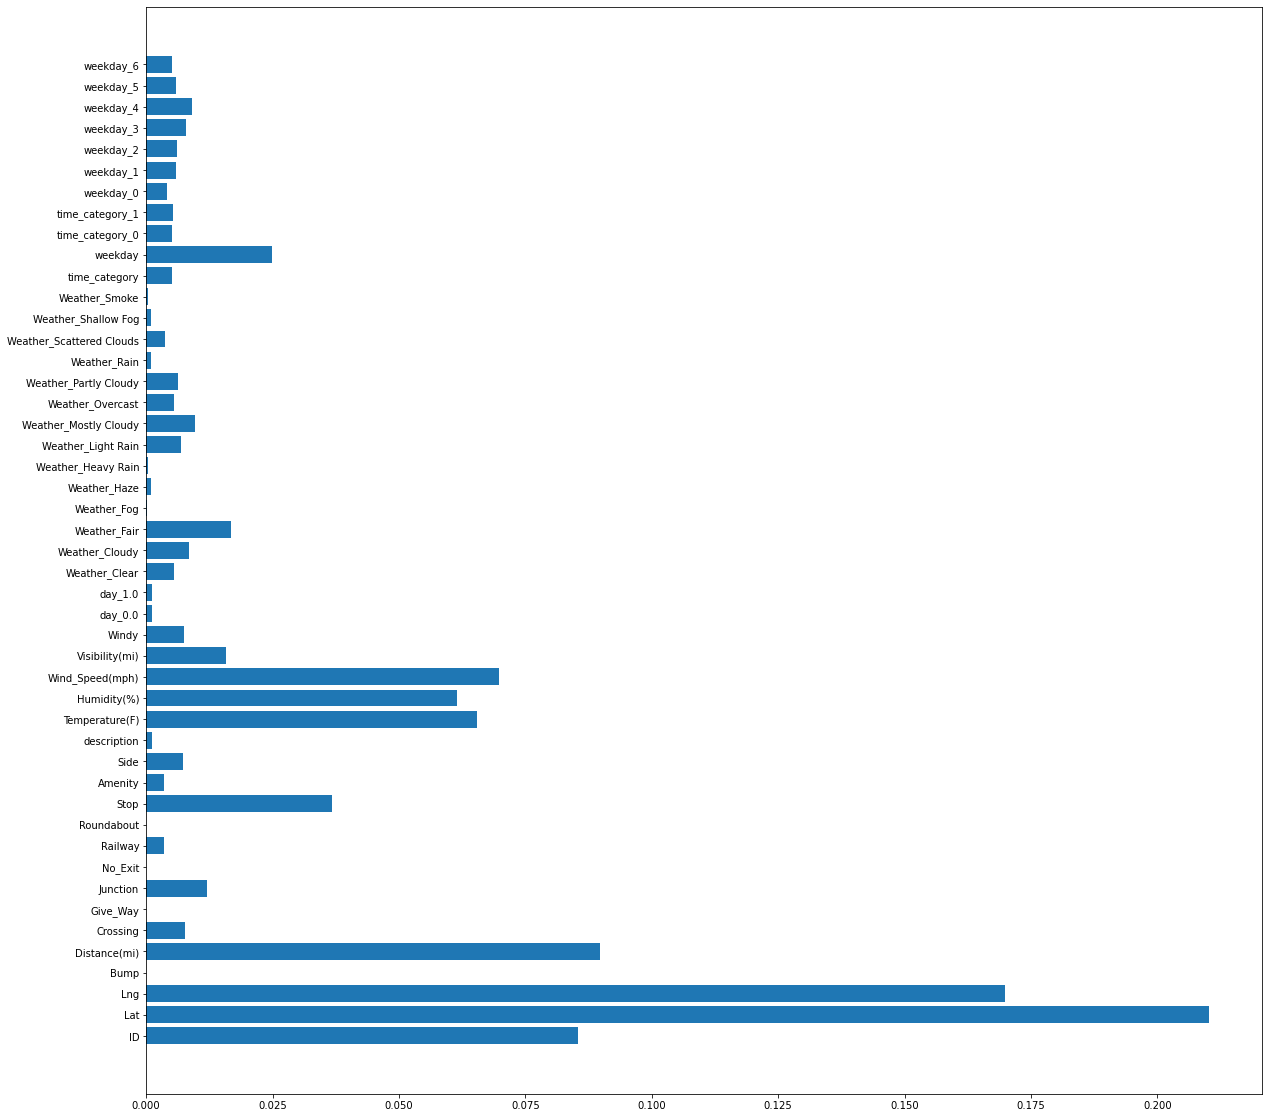

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

from matplotlib import pyplot as plt
rf = RandomForestRegressor(n_estimators=100)
x=train.drop(['Severity','timestamp','Weather_Condition','datedate','date'],axis=1)
rf.fit(x,train['Severity'] )
plt.rcParams["figure.figsize"] = (20,20)
plt.barh( x.columns,rf.feature_importances_)

In [23]:
train

,ID,Lat,Lng,Bump,Distance(mi),Crossing,Give_Way,Junction,No_Exit,Railway,...,weekday,time_category_0,time_category_1,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,37.762150,-122.405660,0.0,0.044,0.0,0.0,0.0,0.0,0.0,...,4,0,1,0,0,0,0,1,0,0
1,1,37.719157,-122.448254,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,1,1,0,0,1,0,0,0,0,0
2,2,37.808498,-122.366852,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,4,1,0,0,0,0,0,1,0,0
3,3,37.785930,-122.391080,0.0,0.009,0.0,0.0,1.0,0.0,0.0,...,6,1,0,0,0,0,0,0,0,1
4,4,37.719141,-122.448457,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,2,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6402,6402,37.740630,-122.407930,0.0,0.368,0.0,0.0,0.0,0.0,0.0,...,6,1,0,0,0,0,0,0,0,1
6403,6403,37.752755,-122.402790,0.0,0.639,0.0,0.0,1.0,0.0,0.0,...,1,0,1,0,1,0,0,0,0,0
6404,6404,37.726304,-122.446015,0.0,0.000,0.0,0.0,1.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,0
6405,6405,37.808090,-122.367211,0.0,0.000,0.0,0.0,1.0,0.0,0.0,...,5,0,1,0,0,0,0,0,1,0


In [24]:
def get_relevant_features(train):
    train=train[['ID','Lat','Lng','Distance(mi)','Stop','Temperature(F)','Humidity(%)','Wind_Speed(mph)','weekday','Severity','Visibility(mi)','Weather_Fair']]
    return train

In [25]:
def get_relevant_features2(train):
    train=train[['ID','Lat','Lng','Distance(mi)','Stop','Temperature(F)','Humidity(%)','Wind_Speed(mph)','weekday','Visibility(mi)','Weather_Fair']]
    return train

In [26]:
train=get_relevant_features(train)

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6406 entries, 0 to 6406
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               6406 non-null   int64  
 1   Lat              6406 non-null   float64
 2   Lng              6406 non-null   float64
 3   Distance(mi)     6406 non-null   float64
 4   Stop             6406 non-null   float64
 5   Temperature(F)   6406 non-null   float64
 6   Humidity(%)      6406 non-null   float64
 7   Wind_Speed(mph)  6406 non-null   float64
 8   weekday          6406 non-null   int64  
 9   Severity         6406 non-null   int64  
 10  Visibility(mi)   6406 non-null   float64
 11  Weather_Fair     6406 non-null   uint8  
dtypes: float64(8), int64(3), uint8(1)
memory usage: 606.8 KB


In [28]:
cor=pd.DataFrame(train[train.columns[0:]].corr()['Severity'][:]).apply(abs).sort_values(by='Severity')
cor

,Severity
Distance(mi),0.013071
Visibility(mi),0.015716
Temperature(F),0.018306
ID,0.021050
Wind_Speed(mph),0.021897
weekday,0.041102
Humidity(%),0.076742
Lat,0.099815
Weather_Fair,0.138609
Lng,0.145331


In [29]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train, test_size=0.20, random_state=42,stratify=train['Severity']) # Try adding `stratify` here

X_train = train_df.drop(columns=['Severity','ID'])
y_train = train_df['Severity']

X_val = val_df.drop(columns=['Severity','ID'])
y_val = val_df['Severity']


In [64]:
from sklearn.ensemble import RandomForestClassifier
    # Create an instance of the classifier
classifier = RandomForestClassifier(max_depth=7, random_state=42)

    # Train the classifier
classifier = classifier.fit(X_train, y_train)

In [65]:
#testing data on training data
print("The accuracy of the classifier on the training set is ", (classifier.score(X_train, y_train)))

The accuracy of the classifier on the training set is  0.8054254488680718


In [66]:
#testing data on validation data
print("The accuracy of the classifier on the validation set is ", (classifier.score(X_val, y_val)))

The accuracy of the classifier on the validation set is  0.7878315132605305


In [33]:
test=mergeholidays(test,holidays)

In [34]:
test=mergeweather(test,weather2)

In [35]:
test=clean(test)
test=encoding(test)

In [36]:
test=get_relevant_features2(test)

In [37]:
X_test = test.drop(columns=['ID'])
y_test_predicted = classifier.predict(X_test)

test['Severity'] = y_test_predicted

